In [14]:
#import xarray
#import fsspec
import numpy as np
#import s3fs
import proplot
import os

from matplotlib import pyplot as plt
import pandas
import json

In [15]:
def set_metadata(tbl, col_meta={}, tbl_meta={}):
    """Store table- and column-level metadata as json-encoded byte strings.

    Table-level metadata is stored in the table's schema.
    Column-level metadata is stored in the table columns' fields.

    To update the metadata, first new fields are created for all columns.
    Next a schema is created using the new fields and updated table metadata.
    Finally a new table is created by replacing the old one's schema, but
    without copying any data.

    Args:
        tbl (pyarrow.Table): The table to store metadata in
        col_meta: A json-serializable dictionary with column metadata in the form
            {
                'column_1': {'some': 'data', 'value': 1},
                'column_2': {'more': 'stuff', 'values': [1,2,3]}
            }
        tbl_meta: A json-serializable dictionary with table-level metadata.
    """
    # Create updated column fields with new metadata
    if col_meta or tbl_meta:
        fields = []
        for col in tbl.schema.names:
            if col in col_meta:
                # Get updated column metadata
                metadata = tbl.field(col).metadata or {}
                for k, v in col_meta[col].items():
                    metadata[k] = json.dumps(v).encode('utf-8')
                # Update field with updated metadata
                fields.append(tbl.field(col).with_metadata(metadata))
            else:
                fields.append(tbl.field(col))
        
        # Get updated table metadata
        tbl_metadata = tbl.schema.metadata or {}
        for k, v in tbl_meta.items():
            if type(v)==bytes:
                tbl_metadata[k] = v
            else:
                tbl_metadata[k] = json.dumps(v).encode('utf-8')

        # Create new schema with updated field metadata and updated table metadata
        schema = pa.schema(fields, metadata=tbl_metadata)

        # With updated schema build new table (shouldn't copy data)
        # tbl = pa.Table.from_batches(tbl.to_batches(), schema)
        tbl = tbl.cast(schema)

    return tbl

In [2]:
def Get_CODA_id(dates,source_data,obs_platform,year,profile_count):
    
    CODA_id_length = 20
    CODA_ID = np.array(['' for _ in range(dates.size)], dtype='S{}'.format(CODA_id_length))
    
    unique_dates = np.unique(dates)

    
    for i_date in unique_dates:
    
        if not pandas.isnull(i_date):
            
            idx_for_date   =  np.nonzero(dates == i_date)[0]
            count_for_date =  idx_for_date.size
            
            for i_index in idx_for_date:
                #print(i_index)
                #CODA_id_current_profiles = source_data + obs_platform + i_date.strftime('%Y%m%d') + f'{i_profile:04}' 
                CODA_id_current_profiles = source_data + obs_platform + np.datetime_as_string(i_date, unit='D').replace('-','') + f'{profile_count:04}'
                CODA_ID[i_index] = CODA_id_current_profiles
                
            #END for i_index
        #if not isnull
    #END for i_date

    bad_dates_idx = np.nonzero(pandas.isnull(dates))[0]
 
    bad_profile_counter = 1
    
    for i_bad_idx in bad_dates_idx:
        CODA_id_current_profiles = source_data + obs_platform + str(year) + 'XXXX' + f'{bad_profile_counter:04}'
        CODA_ID[i_bad_idx] = CODA_id_current_profiles
        bad_profile_counter = bad_profile_counter+1

    return CODA_ID

In [4]:
import sys
sys.path.append('/tube1/cha674/CARS_2022/cars-v2/wodpy/wodpy')
import wodnc

In [5]:
START_YEAR = 2018
END_YEAR   = 2019

In [ ]:
obs_type = ['ctd','xbt','pfl','mrb','gld'] #,'drb'] #,'gld']
#obs_type = ['ctd']

base_s3_url = 's3://noaa-wod-pds'

data_container = {}

output_directory = '/tube1/cha674/CARS_2022_ancillary_data/WOD_2018'

for i_year in range(START_YEAR,END_YEAR+1):

    data_container_for_year = {}
    for i_obs_type in obs_type:
        url = base_s3_url + '/' + str(i_year) + '/wod_' + i_obs_type + '_' + str(i_year) + '.nc' #_pfl_2018.nc'
        print(url)
        fs = s3fs.S3FileSystem(anon=True)
        file_obj = fs.open(url)
        ds = xarray.open_dataset(file_obj,engine='h5netcdf')
        data_container_for_year[i_obs_type] = ds
        
        #Write data out
        if not os.path.isdir(os.path.join(output_directory,str(i_year))):
            os.mkdir(os.path.join(output_directory,str(i_year)))
        print(os.path.join(output_directory,str(i_year),'wod_' + i_obs_type + '_' + str(i_year) + '.nc'))
        ds.to_netcdf(os.path.join(output_directory,str(i_year),'wod_' + i_obs_type + '_' + str(i_year) + '.nc'))
        
    data_container[i_year] = data_container_for_year

In [6]:

WOD_directory = '//oa-decadal-climate/work/observations/WOD2018/'
platforms_to_get = ['ctd','osd','pfl','xbt','mrb','gld']
WOD_file_name_stem = 'wod_'

profile_vars_to_get   = ['Temperature','Salinity','Oxygen','Chlorophyll','Silicate','Phosphate','Nitrate','pH','Alkalinity','tCO2','z']
point_vars_to_get     = ['lat','lon','wod_unique_cast']
ancillary_vars_to_get = ['origflagset','country','dataset','Access_no','Recorder',
                         'dbase_orig','Platform','Project','WOD_cruise_identifier',
                         'Institute','needs_z_fix','Ocean_Vehicle','Temperature_Instrument']

output_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/CODAv1/parquet'

FILL_VALUE = -10000000000.0


column_names = point_vars_to_get.copy()
column_names = column_names.append(profile_vars_to_get)



for i_year in range(START_YEAR,END_YEAR+1):
    print('Working on year: ', i_year)
    for i_platform in platforms_to_get:
        print('Working on platform: ', i_platform)

        file_name  = WOD_file_name_stem + i_platform + '_' + str(i_year) + '.nc'
        WOD_ragged_object = wodnc.Ragged(os.path.join(WOD_directory,str(i_year),file_name))
        
        vars_in_dataset = list(WOD_ragged_object.variables().keys())
        
        
        n_profiles = WOD_ragged_object.ncasts()
        
        
        profile_data_container   = {}
        ancillary_data_container = {}
        attributes_data_container = {}
        
        data_vars_to_get = profile_vars_to_get + point_vars_to_get
        
        #data_vars_to_get.append(point_vars_to_get)
        
        
        for i_var in data_vars_to_get:
            if i_var in vars_in_dataset:
                
                profile_data_container[i_var]  = []
                
                if i_var in profile_vars_to_get:
                    profile_data_container[i_var + '_WODflag']  = []
                    profile_data_container[i_var + '_origflag'] = []
                
        
                
                attributes_data_container[i_var]            = {}
                attributes_data_container[i_var + '_WODflag']  = {}
                attributes_data_container[i_var + '_origflag'] = {}
        
        for i_ancillary_var in ancillary_vars_to_get:
            if i_ancillary_var in vars_in_dataset:
                
                ancillary_data_container[i_ancillary_var]  = []
                
                attributes_data_container[i_ancillary_var] = {}
        
        
        
        vars_to_CODA = list(profile_data_container.keys())
        
        profile_data_container['time']     = []
        profile_data_container['CODA_id']  = []

        
        
        # = list(WOD_ragged_object.variables().keys())

        number_of_levels_by_profile = []
        
        #DEBUG
        n_profiles = 1000
        for i_profile in range(0,n_profiles):
            
             #= pandas.DataFrame(columns=column_names)
            if (i_profile % 1000) ==0:
                print("Profile: ", i_profile, ' of ', n_profiles)
            
            WOD_profile_object   = wodnc.ncProfile(WOD_ragged_object,i_profile)      
            n_levels             = WOD_profile_object.n_levels()
            
            number_of_levels_by_profile.append(n_levels)
            
            for i_var in vars_to_CODA:
                if i_var in vars_in_dataset:
                    if WOD_profile_object.is_level_data(i_var):
                
                        current_variable     = WOD_profile_object.level_unpack(i_var)
                
                        #Test for missing data on profile
                        if current_variable.size != 0:
                            profile_data_container[i_var].append(current_variable)
                        else:
                            profile_data_container[i_var].append(np.repeat(np.nan,n_levels))
                        #END if current_variable.size != 0:
                    
                    elif WOD_profile_object.is_metadata(i_var):
                        
                        current_point_data            = WOD_profile_object.metadata(i_var)
                        
                        profile_data_container[i_var].append( np.repeat(current_point_data,n_levels) )
             
            #END for i_var
            
            #Extract datetimes
            current_time = WOD_profile_object.datetime()
            current_datetime = np.datetime64(current_time).astype('datetime64[s]')
            profile_data_container['time'].append( np.repeat(current_datetime,n_levels) )

            for i_ancillary_var in ancillary_data_container.keys():
                current_ancillary_var = WOD_profile_object.metadata(i_ancillary_var)
                
                if isinstance(current_ancillary_var,str):
                    ancillary_data_container[i_ancillary_var].append(f"{current_ancillary_var:<100}")
                else:
                    ancillary_data_container[i_ancillary_var].append(current_ancillary_var)
                #END if isinstance()
            
            #END for i_ancillary_variable    

            
            source_data   = 'WOD'

            
            #Set the CODA Identifier
            CODA_id = Get_CODA_id( profile_data_container['time'][-1][0],source_data,i_platform,i_year,i_profile)
            profile_data_container['CODA_id'].append(np.repeat(CODA_id,n_levels))
            
            
        #END for i_profile
        #/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/CODAv1/
        #Build Dataframe
        print('Building dataframe')
        wod_dataframe = pandas.DataFrame(columns=profile_data_container.keys())

        for i_var in profile_data_container:
            wod_dataframe[i_var] = np.concatenate(profile_data_container[i_var])
        #END for i_var
        
        for i_ancillary_var in ancillary_data_container.keys():
            #print(i_ancillary_var)
            current_ancillary_var = []
    
            for i_profile in range(0,n_profiles):
                current_ancillary_var.append( np.repeat(ancillary_data_container[i_ancillary_var][i_profile], number_of_levels_by_profile[i_profile]) )
            #END for i_profile    
            n_columns = len(wod_dataframe.columns)

            wod_dataframe.insert(n_columns,i_ancillary_var,np.concatenate(current_ancillary_var) )
                            
        #END for i_ancillary
        
        output_file_name = 'WOD2018_CODA_' + str(i_year) + '_' + str(i_platform) + '.parquet'
        print('Writing file:', output_file_name)
        if not os.path.isdir(os.path.join(output_path,str(i_year))):
            os.mkdir(os.path.join(output_path,str(i_year)))
        wod_dataframe.to_parquet(os.path.join(output_path,str(i_year),output_file_name),engine='pyarrow',compression='snappy')

        sdaa
        
        

Working on year:  2018
Working on platform:  ctd
Profile:  0  of  1000
Building dataframe
Writing file: WOD2018_CODA_2018_ctd.parquet


NameError: name 'sdaa' is not defined

In [55]:
for i_ancillary_var in ancillary_data_container.keys():
    print(i_ancillary_var)
    current_ancillary_var = []
    
    for i_profile in range(0,n_profiles):
         current_ancillary_var.append( np.repeat(ancillary_data_container[i_ancillary_var][i_profile], number_of_levels_by_profile[i_profile]) )
                
    wod_dataframe =  wod_dataframe.assign(i_ancillary_var= np.concatenate(current_ancillary_var) )
            

origflagset
country
dataset
Access_no
Recorder
dbase_orig
Platform
Project
WOD_cruise_identifier
Institute
needs_z_fix
Temperature_Instrument


In [52]:
np.concatenate(current_ancillary_var[i_ancillary_var])

array(['                                                                                                    ',
       '                                                                                                    ',
       '                                                                                                    ',
       ...,
       '                                                                                                    ',
       '                                                                                                    ',
       '                                                                                                    '],
      dtype='<U100')

In [27]:
print('Building dataframe')
wod_dataframe = pandas.DataFrame(columns=profile_data_container.keys())

for i_var in profile_data_container:
    wod_dataframe[i_var] = np.concatenate(profile_data_container[i_var])

Building dataframe


In [28]:
output_file_name = 'WOD2018_CODA_' + str(i_year) + '_' + str(i_platform) + '.parquet'
print('Writing file:', output_file_name)
if not os.path.isdir(os.path.join(output_path,str(i_year))):
    os.mkdir(os.path.join(output_path,str(i_year)))
wod_dataframe.to_parquet(os.path.join(output_path,str(i_year),output_file_name),engine='pyarrow',compression='snappy')  

Writing file: WOD2018_CODA_2018_ctd.parquet


0        [28.78, 28.93, 28.83, 28.5, 25.83, 25.46, 20.4...
1        [28.71, 28.95, 28.88, 28.82, 28.52, 27.66, 26....
2        [29.09, 28.95, 28.87, 28.74, 27.94, 27.26, 24....
3        [28.75, 28.76, 28.75, 28.81, 28.82, 28.59, 27....
4        [28.61, 28.63, 28.74, 28.78, 28.92, 28.87, 28....
                               ...                        
22919    [-0.85, -0.85, -0.86, -1.34, -1.77, -1.66, -1....
22920    [-0.82, -0.9, -1.14, -1.76, -1.51, -1.12, -0.6...
22921    [-1.01, -1.13, -1.79, -1.79, -1.32, 0.48, 0.75...
22922    [-0.17, -0.35, -0.39, -0.49, -1.66, -1.81, -1....
22923    [0.03, -0.01, -0.08, -0.76, -1.55, -1.71, -1.1...
Name: Temperature, Length: 22924, dtype: object

In [18]:
import pyarrow as pa


year_to_get = 2018
output_file_name = 'WOD2018_CODA_' + str(year_to_get) + '_' + str(i_platform) + '.parquet'

wod_dataframe = pandas.read_parquet(os.path.join(output_path,str(year_to_get),output_file_name), engine='pyarrow')

table = pa.Table.from_pandas(wod_dataframe)


#col_meta: A json-serializable dictionary with column metadata in the form
#            {
#                'column_1': {'some': 'data', 'value': 1},
#                'column_2': {'more': 'stuff', 'values': [1,2,3]}
#            }

table_with_metadata = set_metadata(table, col_meta={'Temperature': {'units':'degrees','long_name':'Temperature'}}, tbl_meta={'Parent file':file_name})


In [19]:
table_with_metadata

pyarrow.Table
Temperature: float
Temperature_WODflag: int8
Temperature_origflag: int8
Salinity: double
Salinity_WODflag: double
Salinity_origflag: double
Oxygen: double
Oxygen_WODflag: double
Oxygen_origflag: double
Chlorophyll: double
Chlorophyll_WODflag: double
Chlorophyll_origflag: double
Nitrate: double
Nitrate_WODflag: double
Nitrate_origflag: double
z: float
z_WODflag: int8
z_origflag: int8
lat: double
lon: double
wod_unique_cast: int64
time: timestamp[ms]
CODA_id: binary
origflagset: string
country: string
dataset: string
Access_no: int64
Recorder: string
dbase_orig: string
Platform: string
Project: string
WOD_cruise_identifier: string
Institute: string
needs_z_fix: string
Temperature_Instrument: string
----
Temperature: [[28.78,28.93,28.83,28.5,25.83,...,1.54,1.53,1.52,1.5,1.5]]
Temperature_WODflag: [[0,0,0,0,0,...,0,0,0,0,0]]
Temperature_origflag: [[-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9]]
Salinity: [[33.59000015258789,33.779998779296875,33.939998626708984,33.91999816894531,34.4799

In [24]:
table_with_metadata.field('Temperature').metadata[b'units']

b'"degrees"'

In [33]:


CODA_id = wod_dataframe['CODA_id'].unique()
profile = wod_dataframe.loc[wod_dataframe['CODA_id'] == CODA_id[0]]


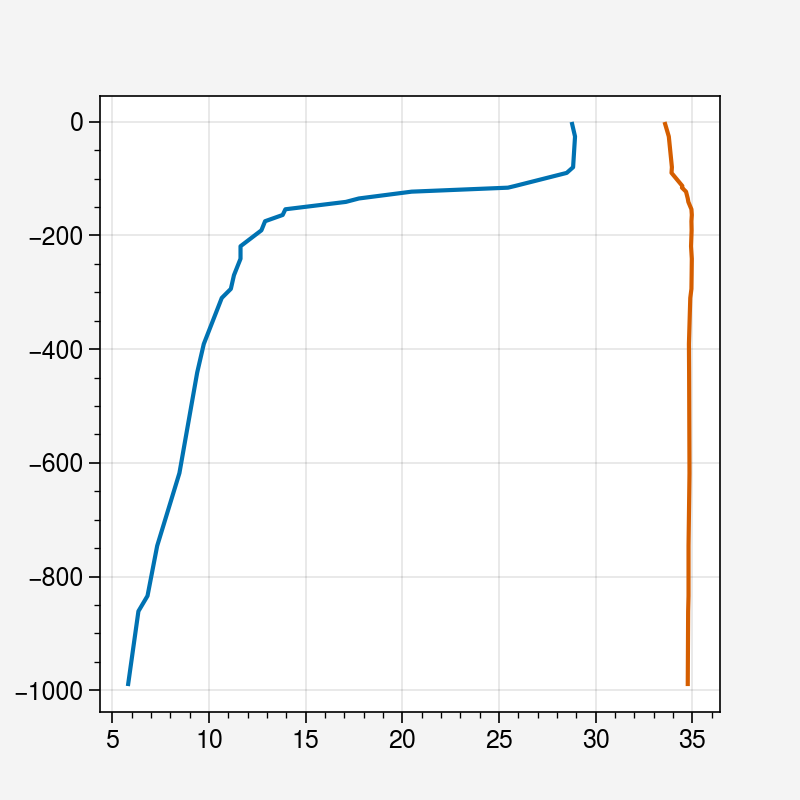

In [39]:
plt.plot(profile['Temperature'].values,-profile['z'].values)
plt.plot(profile['Salinity'].values,-profile['z'].values)

In [37]:
profile['z']

0       4.0
1      26.0
2      80.0
3      90.0
4     113.0
5     116.0
6     123.0
7     135.0
8     141.0
9     154.0
10    164.0
11    175.0
12    191.0
13    219.0
14    241.0
15    270.0
16    294.0
17    310.0
18    391.0
19    441.0
20    618.0
21    746.0
22    834.0
23    861.0
24    989.0
Name: z, dtype: float32

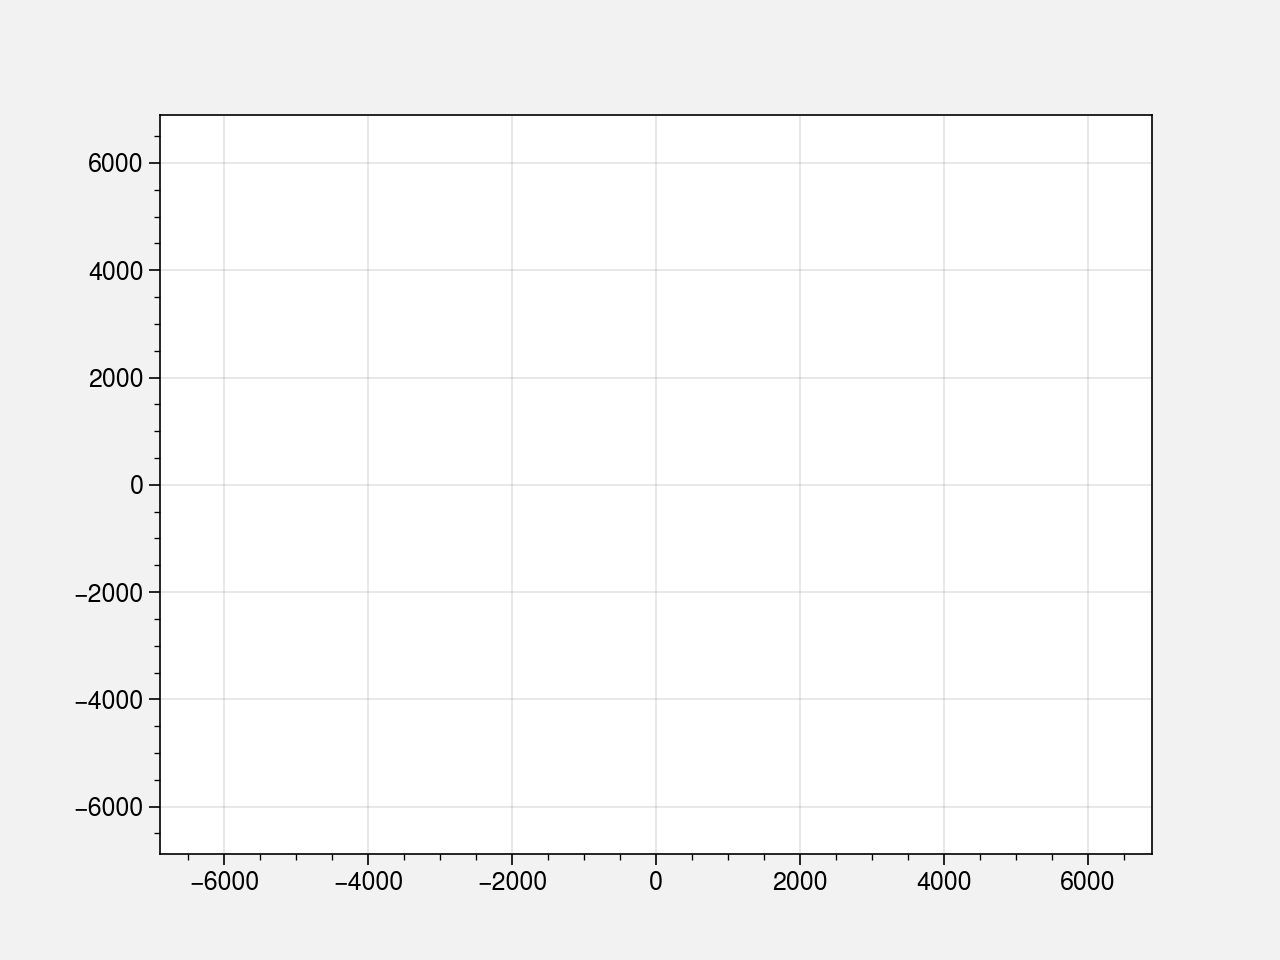

In [121]:

CODA_id = wod_dataframe['CODA_id'].unique()

#first_profile = wod_dataframe.loc[wod_dataframe['CODA_id']==CODA_id[0]]
for i_ancillary_var in ancillary_vars_to_get:
            if i_ancillary_var in vars_in_dataset:
                
                ancillary_data_container[i_ancillary_var]  = 0
                attributes_data_container[i_ancillary_var] = {}
for i_profile in range(0,100):
    #print()
    profile_to_plot = wod_dataframe.loc[wod_dataframe['CODA_id']==CODA_id[i_profile]]

    plt.plot(profile_to_plot['Nitrate'],-profile_to_plot['z'])
#plt.xlim([0,40])

In [58]:
for i_var in profile_data_container:
    print(i_var,len(profile_data_container[i_var]))

Oxygen 300
Oxygen_WODflag 300
Oxygen_origflag 300
Temperature 300
Temperature_WODflag 300
Temperature_origflag 300
Salinity 300
Salinity_WODflag 300
Salinity_origflag 300
Chlorophyll 300
Chlorophyll_WODflag 300
Chlorophyll_origflag 300
Nitrate 300
Nitrate_WODflag 300
Nitrate_origflag 300
z 300
z_WODflag 300
z_origflag 300
lat 300
lon 300
wod_unique_cast 300
time 300


In [ ]:
time_stuff = profile_data_container['time']

for i_profile in range(0,len(time_stuff)):
    print(i_profile)
    print(time_stuff[i_profile])
    print("===================")

In [ ]:
time_stuff = profile_data_container['time']

for i_profile in range(0,len(time_stuff)):
    
    print(i_profile)
    print(time_stuff[i_profile])
    print('=========================')

In [ ]:
first_pass = True
            for i_var in point_vars_to_get:
                
                if i_var in vars_in_dataset:
                
                    current_point_var = WOD_profile_object.metadata(i_var)
                
                    if first_pass == True:
                    
                        current_profile_dataframe = pandas.DataFrame({i_var:np.repeat(current_point_var,n_levels)})
                    
                        first_pass = False
                
                    else:
                        current_profile_dataframe[i_var] = np.repeat(current_point_var,n_levels)
                    #END if first_passtemperature = np.concatenate(profile_data_container['Temperature'])


                else:
                    current_profile_dataframe[i_var] = np.repeat(np.nan,n_levels)

                
            #END for i_var in point_vars_to_get
            
            current_profile_dataframe['time'] = np.datetime64(WOD_profile_object.datetime())


In [20]:
T = WOD_profile_object.level_unpack('Temperature')
S = WOD_profile_object.level_unpack('Salinity')
O2 = WOD_profile_object.level_unpack('Oxygen')


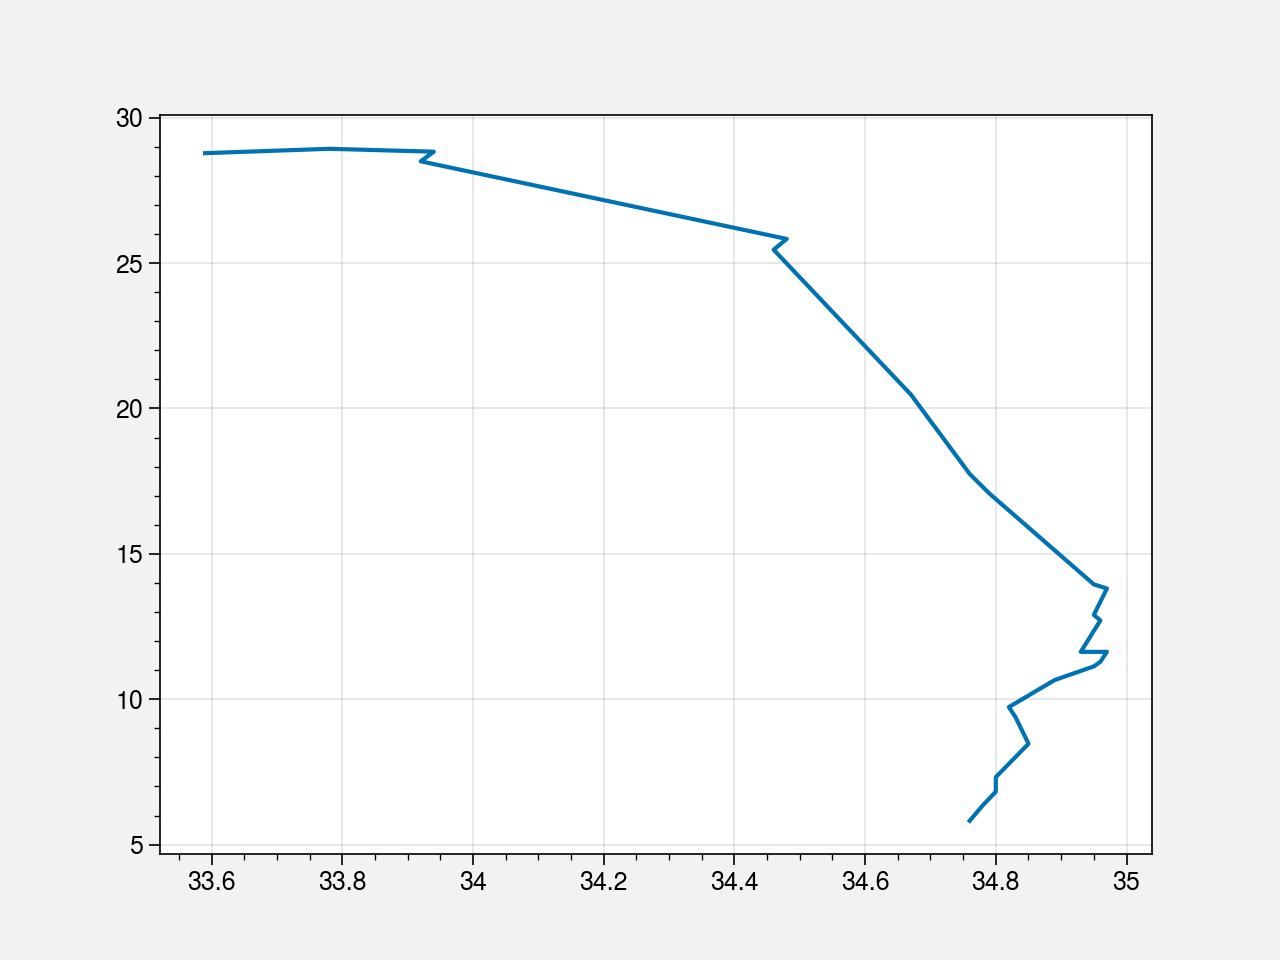

In [23]:
plt.plot(S,T)

In [50]:
lat = pandas.unique(wod_dataframe.loc[wod_dataframe['wod_unique_cast']==21349376]['lat'])
lon = pandas.unique(wod_dataframe.loc[wod_dataframe['wod_unique_cast']==21349376]['lon'])


In [55]:
lat = wod_dataframe['lat']
lon = wod_dataframe['lon']

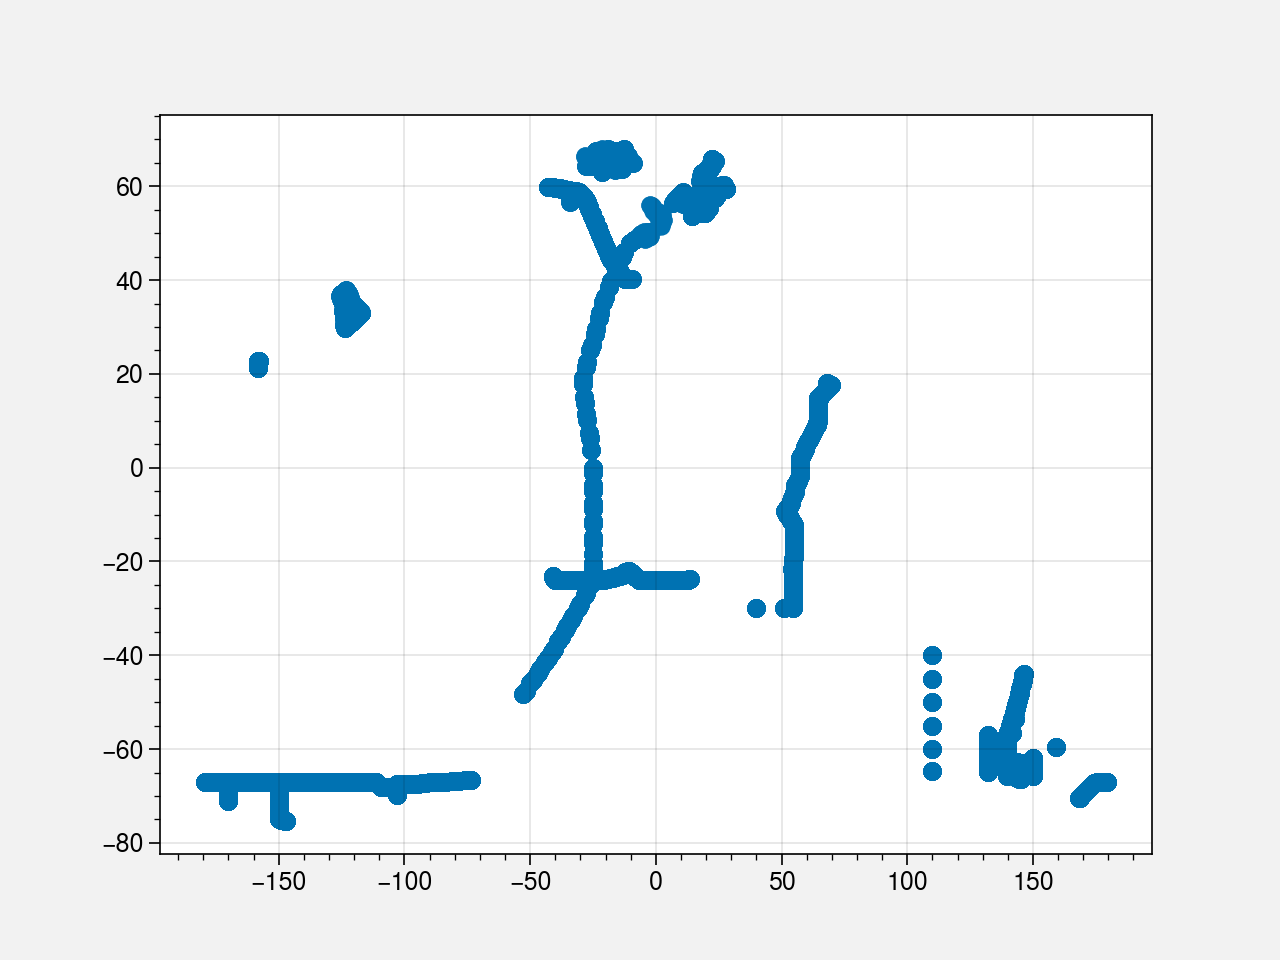

In [56]:
plt.scatter(lon,lat)

In [ ]:
WOD_directory = '//oa-decadal-climate/work/observations/WOD2018/'
platforms_to_get = ['osd','ctd','xbt','pfl','mrb','gld']
WOD_file_name_stem = 'wod_'

profile_vars_to_get = ['Oxygen','Temperature','Salinity','Chlorophyll','Silicate','Phosphate','Nitrate','pH','Alkalinity','tCO2','z']
point_vars_to_get   = ['lat','lon'] #,'time','wod_unique_cast']
ancillary_vars_to_get = ['origflagset','country','dataset','Access_no','Recorder',
                         'dbase_orig','Platform','Project','WOD_cruise_identifier',
                         'Institute','needs_z_fix','Ocean_Vehicle','Temperature_Instrument']

output_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/CODAv1/'

FILL_VALUE = -10000000000.0

for i_year in range(START_YEAR,END_YEAR+1):
    print('Working on year: ', i_year)
    for i_platform in platforms_to_get:
        print('Working on platform: ', i_platform)

        file_name  = WOD_file_name_stem + i_platform + '_' + str(i_year) + '.nc'
        WOD_ragged_object = wodnc.Ragged(os.path.join(WOD_directory,str(i_year),file_name))
        n_profiles = WOD_ragged_object.ncasts()
        
        max_depth_levels = 0for i_ancillary_var in ancillary_vars_to_get:
            if i_ancillary_var in vars_in_dataset:
                
                ancillary_data_container[i_ancillary_var]  = 0
                attributes_data_container[i_ancillary_var] = {}
        
        for i_profile in range(0,n_profiles):
            
            WOD_profile_object = wodnc.ncProfile(WOD_ragged_object,i_profile)
            n_depth_levels  = WOD_profile_object.n_levels()
            
            if n_depth_levels>max_depth_levels:
                max_depth_levels = n_depth_levels
        
         
        #END for i_profile
        vars_in_dataset = list(WOD_ragged_object.variables().keys())
        
        
        profile_data_container   = {}
        ancillary_data_container = {}
        attributes_data_container = {}
        for i_var in profile_vars_to_get:
            if i_var in vars_in_dataset:

                profile_data_container[i_var]               = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='float32')
                profile_data_container[i_var + '_WODflag']  = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='int8')
                profile_data_container[i_var + '_origflag'] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='float32')
                
                attributes_data_container[i_var]            = {}
                attributes_data_container[i_var + '_WODflag']  = {}
                attributes_data_container[i_var + '_origflag'] = {}
            #END if i_var
        #END for i_var

        point_data_container = {}
        for i_var in point_vars_to_get:
            point_data_container[i_var] = np.nan*np.zeros([n_profiles],dtype='float32')
            
            attributes_data_container[i_var] = {}

        point_data_container['time']                 = np.zeros([n_profiles],dtype='datetime64[ns]')
        point_data_container['wod_unique_cast']      = np.zeros([n_profiles],dtype='int32')
        
        attributes_data_container['wod_unique_cast'] = {}
        attributes_data_container['time']            = {}

        
        for i_ancillary_var in ancillary_vars_to_get:
            if i_ancillary_var in vars_in_dataset:
                
                ancillary_data_container[i_ancillary_var]  = 0
                attributes_data_container[i_ancillary_var] = {}

        
        
        #Begin the loop through the profiles
        
        for i_profile in range(0,n_profiles):
            
            if (i_profile % 1000) ==0:
                print("Profile: ", i_profile, ' of ', n_profiles)
            
            WOD_profile_object   = wodnc.ncProfile(WOD_ragged_object,i_profile)                
            
            for i_var in profile_data_container:
                current_variable     = WOD_profile_object.level_unpack(i_var)
                 
                if current_variable.size != 0:
                    #Test for missing data on profile
                    profile_data_container[i_var][i_profile,0:current_variable.size] = current_variable
                    
                    
                #END if current_variable.size != 0:
            #END for i_var
            
            if i_profile ==0:
                for i_var in profile_data_container:
                    variable_attributes = WOD_profile_object.show_variable_attr(i_var)
                    for i_attribute in variable_attributes:
                        attributes_data_container[i_var][i_attribute] = WOD_profile_object.get_variable_attr(i_var,i_attribute)
                    #END for i_attribute
                #for i_var 
            #if i_profile ==0 
            
            point_data_container['wod_unique_cast'][i_profile] = WOD_profile_object.metadata('wod_unique_cast')
            if i_profile==0:
                variable_attributes = WOD_profile_object.show_variable_attr('wod_unique_cast')
                for i_attribute in variable_attributes:
                    attributes_data_container['wod_unique_cast'][i_attribute] = WOD_profile_object.get_variable_attr('wod_unique_cast',i_attribute)
            
            
            
            point_data_container['time'][i_profile] = np.datetime64(WOD_profile_object.datetime())
            if i_profile==0:
                variable_attributes = WOD_profile_object.show_variable_attr('time')
                for i_attribute in variable_attributes:
                    attributes_data_container['time'][i_attribute] = WOD_profile_object.get_variable_attr('time',i_attribute)
            
            for i_var in point_vars_to_get:
                if i_var in vars_in_dataset:
                    point_data_container[i_var][i_profile] = WOD_profile_object.metadata(i_var)
                    
                    if i_profile==0:
                        variable_attributes = WOD_profile_object.show_variable_attr(i_var)
                        for i_attribute in variable_attributes:
                            
                            attributes_data_container[i_var][i_attribute] = WOD_profile_object.get_variable_attr(i_var,i_attribute)
                #END if i_var
            #END for i_var
            
            
            for i_ancillary_var in ancillary_data_container.keys():
                current_ancillary_var = WOD_profile_object.metadata(i_ancillary_var)
                #print(type(current_ancillary_var))
                
                
                if i_profile ==0:
                    var_type = type(current_ancillary_var)
                    if var_type is str:
                        
                        ancillary_data_container[i_ancillary_var] = np.zeros([n_profiles],dtype='S{}'.format(100))
                    else:
                        ancillary_data_container[i_ancillary_var] = np.zeros([n_profiles],dtype=var_type)
                    #END if var_type=='str'
                    

                    ancillary_variable_attributes = WOD_profile_object.show_variable_attr(i_ancillary_var)

                    for i_attribute in ancillary_variable_attributes:
                         attributes_data_container[i_ancillary_var][i_attribute] = WOD_profile_object.get_variable_attr(i_ancillary_var,i_attribute)

                    #END for i_attribute
                #END if i_profile = 0
                
                ancillary_data_container[i_ancillary_var][i_profile] = current_ancillary_var

            #END for i_ancillary_var
            
            if i_profile==0:
                crs_attribs = {}
                crs = WOD_profile_object.r.variables()['crs'][:]

                for i_attr in WOD_profile_object.show_variable_attr('crs'):
                    crs_attribs[i_attr] = WOD_profile_object.get_variable_attr('crs',i_attr)
            
        #END for i_profile
        
        
        
        cast_index = np.arange(1,n_profiles+1)
        
        
        
        CODA_output_dataset = xarray.DataArray(point_data_container['wod_unique_cast'],dims=['cast'],coords={'cast':cast_index},attrs = attributes_data_container['wod_unique_cast'])
        CODA_output_dataset = CODA_output_dataset.to_dataset(name='WOD_id')                                  
        
        
        CODA_output_dataset['time'] = xarray.DataArray(point_data_container['time'],dims=['cast'],coords={'cast':cast_index} ) #,attrs = attributes_data_container['time'])
        CODA_output_dataset['time'].encoding['units'] = 'days since 1770-01-01T00:00:00+00:00'
        CODA_output_dataset['time'].encoding['calendar'] = 'proleptic_gregorian'
        CODA_output_dataset['time'].encoding['_FillValue'] = FILL_VALUE

        
        
        #Add the point or cast information (lat and lon)
        for i_var in point_vars_to_get:
            CODA_output_dataset[i_var] = xarray.DataArray(point_data_container[i_var],dims=['cast'],coords={'cast':cast_index},attrs = attributes_data_container[i_var])
            CODA_output_dataset[i_var] = CODA_output_dataset[i_var].fillna(FILL_VALUE)
            CODA_output_dataset[i_var].attrs['_FillValue'] = FILL_VALUE
        #END for i_var
            
        #Add the ancillary data
        for i_ancillary_var in ancillary_data_container.keys():
            CODA_output_dataset[i_ancillary_var] = xarray.DataArray(ancillary_data_container[i_ancillary_var],dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attributes_data_container[i_ancillary_var])
            if '_FillValue' in CODA_output_dataset[i_ancillary_var].attrs:
                #print('found fill value')
                #print(CODA_output_dataset[i_ancillary_var])
                CODA_output_dataset[i_ancillary_var].attrs['_FillValue'] = FILL_VALUE
                CODA_output_dataset[i_ancillary_var] = CODA_output_dataset[i_ancillary_var].fillna(FILL_VALUE)
            #END if 
        #END for i_ancillary_var
            
            
        #Add the profile data
        for i_var in profile_data_container.keys():
            CODA_output_dataset[i_var]  = xarray.DataArray(profile_data_container[i_var],dims=['cast','z_index'],
                                                            coords= {'cast':cast_index,'z_index':np.arange(0,max_depth_levels,1)}, attrs = attributes_data_container[i_var])
            
            CODA_output_dataset[i_var] = CODA_output_dataset[i_var].fillna(FILL_VALUE)
            CODA_output_dataset[i_var].attrs['_FillValue'] = FILL_VALUE
        #END for i_var
        
        CODA_output_dataset['crs']       = xarray.DataArray(crs,dims=[],attrs = crs_attribs)        
        
        source_data   = 'WOD'
        CODA_dates    = CODA_output_dataset['time'].dt.date.values

        CODA_ID = Get_CODA_id(CODA_dates,source_data,i_platform,i_year)
        
        
        CODA_output_dataset['CODA_id'] = xarray.DataArray(CODA_ID,dims=['cast'],coords={'cast':cast_index},
                                                          attrs={'Comment':'Unique CODA identifier with format <Source Dataset><Obs Platform><Counter for date><YYYYMMDD>'})
        CODA_output_dataset.attrs = {'Parent ragged array file':file_name}
        
        output_file_name = 'WOD2018_CODA_' + str(i_year) + '_' + str(i_platform) + '.nc'
        print('Writing file:', output_file_name)
        if not os.path.isdir(os.path.join(output_path,str(i_year))):
            os.mkdir(os.path.join(output_path,str(i_year)))
    
        CODA_output_dataset.to_netcdf(os.path.join(output_path,str(i_year),output_file_name)) #,encoding=encoding) #,engine='netcdf4')

Working on year:  2005
Working on platform:  osd
Profile:  0  of  14845
Profile:  1000  of  14845
Profile:  2000  of  14845
Profile:  3000  of  14845
Profile:  4000  of  14845
Profile:  5000  of  14845
Profile:  6000  of  14845
Profile:  7000  of  14845
Profile:  8000  of  14845
Profile:  9000  of  14845
Profile:  10000  of  14845
Profile:  11000  of  14845
Profile:  12000  of  14845
Profile:  13000  of  14845
Profile:  14000  of  14845
Writing file: WOD2018_CODA_2005_osd.nc
Working on platform:  ctd
Profile:  0  of  26194
Profile:  1000  of  26194
Profile:  2000  of  26194
Profile:  3000  of  26194
Profile:  4000  of  26194
Profile:  5000  of  26194
Profile:  6000  of  26194
Profile:  7000  of  26194
Profile:  8000  of  26194
Profile:  9000  of  26194
Profile:  10000  of  26194
Profile:  11000  of  26194
Profile:  12000  of  26194
Profile:  13000  of  26194
Profile:  14000  of  26194
Profile:  15000  of  26194
Profile:  16000  of  26194
Profile:  17000  of  26194
Profile:  18000  of  

In [4]:
def Get_CODA_id(dates,source_data,obs_platform,year):
    
    CODA_id_length = 20
    CODA_ID = np.array(['' for _ in range(dates.size)], dtype='S{}'.format(CODA_id_length))
    
    unique_dates = np.unique(CODA_dates)

    
    for i_date in unique_dates:
    
        if not pandas.isnull(i_date):
            
            idx_for_date   =  np.nonzero(dates == i_date)[0]
            count_for_date =  idx_for_date.size
            i_profile = 1
            
            for i_index in idx_for_date:
                #print(i_index)
                CODA_id_current_profiles = source_data + obs_platform + i_date.strftime('%Y%m%d') + f'{i_profile:04}'
                CODA_ID[i_index] = CODA_id_current_profiles
                i_profile = i_profile+1
                
            #END for i_index
        #if not isnull
    #END for i_date

    bad_dates_idx = np.nonzero(pandas.isnull(dates))[0]
 
    bad_profile_counter = 1
    
    for i_bad_idx in bad_dates_idx:
        CODA_id_current_profiles = source_data + obs_platform + str(year) + 'XXXX' + f'{bad_profile_counter:04}'
        CODA_ID[i_bad_idx] = CODA_id_current_profiles
        bad_profile_counter = bad_profile_counter+1

    return CODA_ID